In [1]:
import geopandas as gpd
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/michaelrosen/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.2-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
streets = gpd.GeoDataFrame()

In [3]:
file_list = glob.glob('*shp')

In [4]:
for file in file_list:
    ds = gpd.read_file(file)
    streets = gpd.GeoDataFrame(pd.concat([streets, ds], ignore_index=True))

In [5]:
streets['adj_name'] = streets['name'].str.extract(r'^([^/]*)')

In [6]:
streets['adj_name_2'] = streets['adj_name'].str.replace('(North|East|West|South)\s', '', regex=True)
streets['adj_name_2'] = streets['adj_name_2'].str.rstrip()

In [7]:
crashes = pd.read_csv('/Users/michaelrosen/Desktop/Capstone/Crash .csvs/york_and_silverlake_crashes.csv')

In [8]:
streets_list = ['YORK', 'BRONSON', 'AVENUE 64', 'REDONDO','4TH','RIMPAU','WABASH','TUJUNGA','EDGEMONT', 'CRESCENT HEIGHTS', 'GRIFFIN', '54TH','LINCOLN PARK','19TH', '108TH', '92ND','EVERGREEN','TOWNSEND','COLFAX', 'HAUSER', 'JEFFERSON','BEVERLY GLEN','8TH','STRATHERN','GOWER','SILVER LAKE', 'FULTON', 'WILTON', 'BURBANK','NATIONAL']

In [9]:
target_crs = 'EPSG:26911'
streets = streets.to_crs(target_crs)
distance=8
streets['buffer_geom'] = streets.geometry.buffer(distance)

In [10]:
crashes_gdf = gpd.GeoDataFrame(
    crashes, geometry=gpd.points_from_xy(crashes.POINT_X, crashes.POINT_Y))

In [11]:
crashes_gdf = crashes_gdf.set_crs(epsg=4326)

In [12]:
crashes_gdf = crashes_gdf.to_crs(target_crs)

In [13]:
streets = streets[['adj_name_2', 'buffer_geom']]

In [14]:
streets_gdf = gpd.GeoDataFrame(streets, geometry='buffer_geom')

In [15]:
join = gpd.sjoin(streets_gdf, crashes_gdf, how='left', predicate='intersects')

In [16]:
filtered_join = join[join['PRIMARY_RD'].str.contains('|'.join(streets_list), case=False, na=False)]

In [17]:
streets_dict = {
    '2011-01-02': ['York Boulevard', 'Bronson Avenue', 'Avenue 64', 'Redondo Boulevard', '4th Street', 'Rimpau Boulevard', 'Wabash Avenue', 'Tujunga Avenue'],
    '2015-08-06': ['Edgemont Street', 'Crescent Heights Boulevard', 'Griffin Avenue', '54th Street', 'Lincoln Park Avenue'],
    '2019-09-09': ['19th Street', '108th Street', '92nd Street', 'Evergreen Avenue', 'Townsend Avenue'],
    '2021-08-03': ['Colfax Avenue', 'Hauser Boulevard', 'Jefferson Boulevard', 'Beverly Glen Boulevard', '8th Street', 'Strathern Street', 'Gower Street'],
    '2011-01-01': ['Silver Lake Boulevard', 'Fulton Avenue', 'Wilton Place', 'Burbank Boulevard', 'National Boulevard']
}

dates = pd.to_datetime(list(streets_dict.keys()))

df = pd.DataFrame(columns=['adj_name_2', 'crash_counts', 'days_elapsed'])

end_date = pd.Timestamp('2022-12-31')
days_elapsed = (end_date - dates).days

# Loop through dictionary and filter filtered_join DataFrame
# Loop through dictionary and filter filtered_join DataFrame
for date, streets in streets_dict.items():
    filtered_data = filtered_join[(filtered_join['adj_name_2'].isin(streets)) & (pd.to_datetime(filtered_join['COLLISION_DATE']) > pd.to_datetime(date))]
    counts = filtered_data['adj_name_2'].value_counts()
    
    # Add missing street names with zero counts
    missing_streets = set(streets) - set(counts.index)
    missing_counts = pd.Series(0, index=list(missing_streets))
    counts = counts.append(missing_counts)
    
    counts_df = pd.DataFrame({'adj_name_2': counts.index, 'crash_counts': counts.values})
    days_elapsed_df = pd.DataFrame({'days_elapsed': [days_elapsed[dates == pd.to_datetime(date)][0]] * len(counts)})
    merged_df = pd.concat([counts_df, days_elapsed_df], axis=1)
    df = pd.concat([df, merged_df], axis=0, ignore_index=True)


In [18]:
crash_counts = df

In [19]:
fatal_severe_crashes = filtered_join[filtered_join['COLLISION_SEVERITY'].isin([1.0, 2.0])]

In [20]:
new_df = pd.DataFrame(columns=['adj_name_2', 'fatal_severe_crash_counts', 'days_elapsed'])

for date, streets in streets_dict.items():
    filtered_data = fatal_severe_crashes[(fatal_severe_crashes['adj_name_2'].isin(streets)) & (pd.to_datetime(fatal_severe_crashes['COLLISION_DATE']) > pd.to_datetime(date))]
    counts = filtered_data['adj_name_2'].value_counts()
    counts_df = pd.DataFrame({'adj_name_2': streets})
    counts_df['fatal_severe_crash_counts'] = counts_df['adj_name_2'].map(counts).fillna(0)
    days_elapsed_df = pd.DataFrame({'days_elapsed': [days_elapsed[dates == pd.to_datetime(date)][0]] * len(streets)})
    merged_df = pd.concat([counts_df, days_elapsed_df], axis=1)
    new_df = pd.concat([new_df, merged_df], axis=0, ignore_index=True)


In [21]:
fatal_severe_crashes = new_df

In [22]:
ped_bike_crashes = filtered_join[(filtered_join['PEDESTRIAN_ACCIDENT'] == 'Y') | (filtered_join['BICYCLE_ACCIDENT'] == 'Y')]

In [23]:
ped_bike_df = pd.DataFrame(columns=['adj_name_2', 'ped_crash_counts'])

for date, streets in streets_dict.items():
    filtered_data = ped_bike_crashes[(ped_bike_crashes['adj_name_2'].isin(streets)) & (pd.to_datetime(ped_bike_crashes['COLLISION_DATE']) > pd.to_datetime(date))]
    counts = filtered_data['adj_name_2'].value_counts()
    counts_df = pd.DataFrame({'adj_name_2': streets})
    counts_df['ped_crash_counts'] = counts_df['adj_name_2'].map(counts).fillna(0)
    merged_df = pd.concat([counts_df], axis=1)
    ped_bike_df = pd.concat([ped_bike_df, merged_df], axis=0, ignore_index=True)


In [24]:
AADT=pd.read_excel('/Users/michaelrosen/Desktop/Capstone/AADT_Counts/Streetlight_AADT_Counts_FINAL.xlsx')

In [25]:
all_crashes = crash_counts.merge(fatal_severe_crashes, on = 'adj_name_2',how='left')

In [26]:
all_crashes = all_crashes.merge(ped_bike_df, on = 'adj_name_2',how='left')

In [27]:
all_crashes = all_crashes.merge(AADT,left_on = 'adj_name_2',right_on = 'Zone Name',how='left')

In [28]:
all_crashes['VMT'] = all_crashes['Miles']*all_crashes['AADT']*all_crashes['days_elapsed_x']
all_crashes['crashes_per_million_VMT'] = all_crashes['crash_counts']/(all_crashes['VMT']/1000000)
all_crashes['fatal_severe_crashes_per_million_VMT'] = all_crashes['fatal_severe_crash_counts']/(all_crashes['VMT']/1000000)
all_crashes['bike_ped_crashes_per_million_VMT'] = all_crashes['ped_crash_counts']/(all_crashes['VMT']/1000000)

In [29]:
treatment_corridors_short = ['York','Colfax','19th','Edgemont','Silver Lake']
treatment_corridors_df = all_crashes[all_crashes['CLOSEST'] == "Treatment Corridor"]

In [30]:
# Calculate the mean crash counts for the control and comparison corridors
treatment_mean_total = all_crashes.loc[all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'crashes_per_million_VMT'].mean()
comparison_mean_total = all_crashes.loc[~all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'crashes_per_million_VMT'].mean()

# Calculate the percentage difference in means
percent_diff_total = (comparison_mean_total - treatment_mean_total) / treatment_mean_total * 100


In [31]:
treatment_mean_total

1.4030231614355597

In [32]:
comparison_mean_total

2.0029429626910487

In [33]:
percent_diff_total

42.75908037338862

In [34]:
# Calculate the mean fatal/severe crash counts for the control and comparison corridors
treatment_mean_fatal_severe = all_crashes.loc[all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'fatal_severe_crashes_per_million_VMT'].mean()
comparison_mean_fatal_severe = all_crashes.loc[~all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'fatal_severe_crashes_per_million_VMT'].mean()

# Calculate the percentage difference in means
percent_diff_fatal_severe = (comparison_mean_fatal_severe - treatment_mean_fatal_severe) / treatment_mean_fatal_severe * 100


In [35]:
percent_diff_fatal_severe

104.36339253441751

In [36]:
# Calculate the mean fatal/severe crash counts for the control and comparison corridors
treatment_mean_ped_bike = all_crashes.loc[all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'bike_ped_crashes_per_million_VMT'].mean()
comparison_mean_ped_bike = all_crashes.loc[~all_crashes['adj_name_2'].isin(['York Boulevard', 'Edgemont Street', '19th Street', 'Colfax Avenue', 'Silver Lake Boulevard']), 'bike_ped_crashes_per_million_VMT'].mean()

# Calculate the percentage difference in means
percent_diff_ped_bike = (comparison_mean_ped_bike - treatment_mean_ped_bike) / treatment_mean_ped_bike * 100


In [37]:
percent_diff_ped_bike

19.852495315925374

In [38]:
from tabulate import tabulate

data = [
    ["Total Crashes", treatment_mean_total, comparison_mean_total, percent_diff_total],
    ["Fatal and Severe Crashes", treatment_mean_fatal_severe, comparison_mean_fatal_severe, percent_diff_fatal_severe],
    ["Pedestrian and Bike Crashes", treatment_mean_ped_bike, comparison_mean_ped_bike, percent_diff_ped_bike],
]

headers = ["Crashes (per million VMT)","Treatment", "Comparison", "% Difference"]

table = tabulate(data, headers=headers, tablefmt="simple", floatfmt=".2f")

df = pd.DataFrame(data, columns=headers)

# Save the DataFrame as an Excel file
df.to_excel('table_data_summary_findings.xlsx', index=False)

In [39]:
# Extract the data from the DataFrame columns
data = treatment_corridors_df[['adj_name_2', 'Limit 1', 'Limit 2','Miles','AADT','crashes_per_million_VMT']].values.tolist()

# Define the headers
headers = ['Treatment Corridor','Limit 1', 'Limit 2','Length (mi.)','AADT','Crashes/1M VMT']

# Generate the table using tabulate
table = tabulate(data, headers=headers, tablefmt="simple_outline", floatfmt=".2f")

df = pd.DataFrame(data, columns=headers)

# Save the DataFrame as an Excel file
df.to_excel('table_data_treatment_streets.xlsx', index=False)

In [40]:
for comparison_group in treatment_corridors_short:
    df = all_crashes[all_crashes['CLOSEST'] ==  comparison_group]
    data = df[['adj_name_2', 'Limit 1', 'Limit 2','Miles','AADT','crashes_per_million_VMT']].values.tolist()

# Define the headers
    headers = ['Comparison Group','Limit 1', 'Limit 2','Length (mi.)','AADT','Crashes/1M VMT']

# Generate the table using tabulate
    table = tabulate(data, headers=headers, tablefmt="simple", floatfmt=".2f")

# Print the table
    df = pd.DataFrame(data, columns=headers)

# Save the DataFrame as an Excel file
    df_table = pd.DataFrame(data, columns=headers)

    # Define the file name for the specific comparison group
    file_name = f'table_data_{comparison_group.replace(" ", "_")}.xlsx'

    # Save the DataFrame as an Excel file
    df_table.to_excel(file_name, index=False)

/var/folders/bf/7kjr62fs6wq3x9hlt0xsr0w40000gn/T/ipykernel_35070/1859122264.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


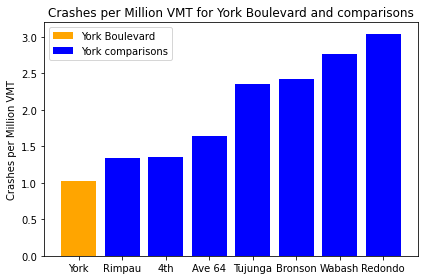

In [41]:
# Filter the dataframe for the specific rows
row_york_blvd = all_crashes[all_crashes['adj_name_2'] == 'York Boulevard']
rows_york = all_crashes[all_crashes['CLOSEST'] == 'York']

# Sort the rows based on 'crashes_per_million_VMT' in ascending order
row_york_blvd_sorted = row_york_blvd.sort_values('crashes_per_million_VMT')
rows_york_sorted = rows_york.sort_values('crashes_per_million_VMT')

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the bar for 'York Boulevard'
ax.bar(row_york_blvd_sorted['adj_name_2'], row_york_blvd_sorted['crashes_per_million_VMT'], color='orange', label='York Boulevard')

# Plot the bar for 'York'
ax.bar(rows_york_sorted['adj_name_2'], rows_york_sorted['crashes_per_million_VMT'], color='blue', label='York comparisons')

# Set the plot title and labels
plt.title('Crashes per Million VMT for York Boulevard and comparisons')
plt.ylabel('Crashes per Million VMT')

# Rotate x-axis labels if needed
xtick_labels = ['York','Rimpau','4th','Ave 64','Tujunga','Bronson','Wabash','Redondo']
ax.set_xticklabels(xtick_labels)

fig.tight_layout()

# Add a legend
plt.legend()

# Show the plot
plt.savefig('york_crashes.png')


/var/folders/bf/7kjr62fs6wq3x9hlt0xsr0w40000gn/T/ipykernel_35070/693505039.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


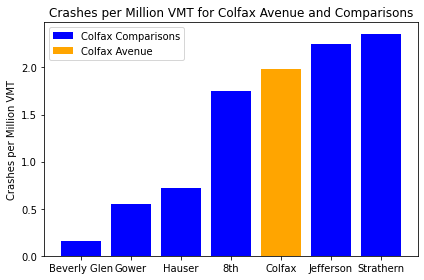

In [42]:
# Filter the dataframe for the specific rows
row_colfax_blvd = all_crashes[all_crashes['adj_name_2'] == 'Colfax Avenue']
rows_colfax = all_crashes[all_crashes['CLOSEST'] == 'Colfax']

# Concatenate the rows together
concatenated_rows = pd.concat([rows_colfax, row_colfax_blvd])

# Sort the rows based on 'crashes_per_million_VMT' in ascending order
sorted_rows = concatenated_rows.sort_values('crashes_per_million_VMT')

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the bar for 'colfax Boulevard'
ax.bar(sorted_rows['adj_name_2'], sorted_rows['crashes_per_million_VMT'], color='blue', label='Colfax Comparisons')
ax.bar(row_colfax_blvd['adj_name_2'], row_colfax_blvd['crashes_per_million_VMT'], color='orange', label='Colfax Avenue')

# Set the plot title and labels
plt.title('Crashes per Million VMT for Colfax Avenue and Comparisons')
plt.ylabel('Crashes per Million VMT')

# Rotate x-axis labels if needed
xtick_labels = ['Beverly Glen','Gower','Hauser','8th','Colfax','Jefferson','Strathern']
ax.set_xticklabels(xtick_labels)

fig.tight_layout()

# Add a legend
plt.legend()

# Show the plot
plt.savefig('colfax_crashes.png')


/var/folders/bf/7kjr62fs6wq3x9hlt0xsr0w40000gn/T/ipykernel_35070/2529480059.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


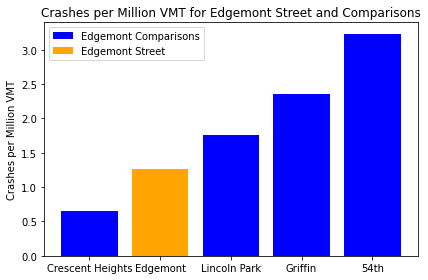

In [43]:
# Filter the dataframe for the specific rows
row_Edgemont_blvd = all_crashes[all_crashes['adj_name_2'] == 'Edgemont Street']
rows_Edgemont = all_crashes[all_crashes['CLOSEST'] == 'Edgemont']

# Concatenate the rows together
concatenated_rows = pd.concat([rows_Edgemont, row_Edgemont_blvd])

# Sort the rows based on 'crashes_per_million_VMT' in ascending order
sorted_rows = concatenated_rows.sort_values('crashes_per_million_VMT')

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the bar for 'Edgemont Boulevard'
ax.bar(sorted_rows['adj_name_2'], sorted_rows['crashes_per_million_VMT'], color='blue', label='Edgemont Comparisons')
ax.bar(row_Edgemont_blvd['adj_name_2'], row_Edgemont_blvd['crashes_per_million_VMT'], color='orange', label='Edgemont Street')

# Set the plot title and labels
plt.title('Crashes per Million VMT for Edgemont Street and Comparisons')
plt.ylabel('Crashes per Million VMT')

# Rotate x-axis labels if needed
xtick_labels = ['Crescent Heights','Edgemont','Lincoln Park','Griffin','54th']
ax.set_xticklabels(xtick_labels)

fig.tight_layout()

# Add a legend
plt.legend()

# Show the plot
plt.savefig('edgemont_crashes.png')


/var/folders/bf/7kjr62fs6wq3x9hlt0xsr0w40000gn/T/ipykernel_35070/2368577097.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


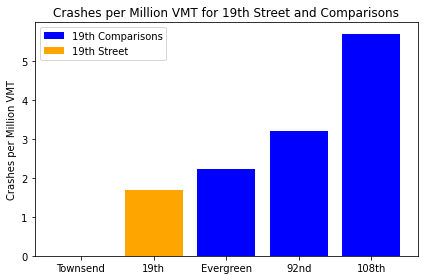

In [44]:
# Filter the dataframe for the specific rows
row_19th_blvd = all_crashes[all_crashes['adj_name_2'] == '19th Street']
rows_19th = all_crashes[all_crashes['CLOSEST'] == '19th']

# Concatenate the rows together
concatenated_rows = pd.concat([rows_19th, row_19th_blvd])

# Sort the rows based on 'crashes_per_million_VMT' in ascending order
sorted_rows = concatenated_rows.sort_values('crashes_per_million_VMT')

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the bar for '19th Boulevard'
ax.bar(sorted_rows['adj_name_2'], sorted_rows['crashes_per_million_VMT'], color='blue', label='19th Comparisons')
ax.bar(row_19th_blvd['adj_name_2'], row_19th_blvd['crashes_per_million_VMT'], color='orange', label='19th Street')

# Set the plot title and labels
plt.title('Crashes per Million VMT for 19th Street and Comparisons')
plt.ylabel('Crashes per Million VMT')

# Rotate x-axis labels if needed
xtick_labels = ['Townsend','19th','Evergreen','92nd','108th']
ax.set_xticklabels(xtick_labels)
fig.tight_layout()

# Add a legend
plt.legend()

# Show the plot
plt.savefig('19th_crashes.png')


/var/folders/bf/7kjr62fs6wq3x9hlt0xsr0w40000gn/T/ipykernel_35070/549784280.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_labels)


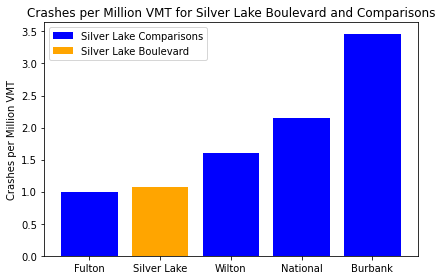

In [45]:
# Filter the dataframe for the specific rows
row_Silver_Lake_blvd = all_crashes[all_crashes['adj_name_2'] == 'Silver Lake Boulevard']
rows_Silver_Lake = all_crashes[all_crashes['CLOSEST'] == 'Silver Lake']

# Concatenate the rows together
concatenated_rows = pd.concat([rows_Silver_Lake, row_Silver_Lake_blvd])

# Sort the rows based on 'crashes_per_million_VMT' in ascending order
sorted_rows = concatenated_rows.sort_values('crashes_per_million_VMT')

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the bar for 'Silver_Lake Boulevard'
ax.bar(sorted_rows['adj_name_2'], sorted_rows['crashes_per_million_VMT'], color='blue', label='Silver Lake Comparisons')
ax.bar(row_Silver_Lake_blvd['adj_name_2'], row_Silver_Lake_blvd['crashes_per_million_VMT'], color='orange', label='Silver Lake Boulevard')

# Set the plot title and labels
plt.title('Crashes per Million VMT for Silver Lake Boulevard and Comparisons')
plt.ylabel('Crashes per Million VMT')

# Rotate x-axis labels if needed
xtick_labels = ['Fulton','Silver Lake','Wilton','National','Burbank']
ax.set_xticklabels(xtick_labels)

fig.tight_layout()

# Add a legend
plt.legend()

# Show the plot
plt.savefig('silver_lake_crashes.png')


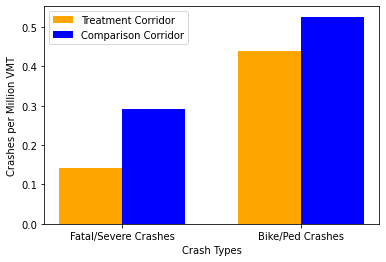

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the dataframe based on "CLOSEST" column
treatment_corr = all_crashes[all_crashes['CLOSEST'] == "Treatment Corridor"]
non_treatment_corr = all_crashes[all_crashes['CLOSEST'] != "Treatment Corridor"]

# Calculate the means
mean_treatment_corr = treatment_corr[['fatal_severe_crashes_per_million_VMT', 'bike_ped_crashes_per_million_VMT']].mean()
mean_non_treatment_corr = non_treatment_corr[['fatal_severe_crashes_per_million_VMT', 'bike_ped_crashes_per_million_VMT']].mean()

# Create the bar chart
categories = ['Fatal/Severe Crashes', 'Bike/Ped Crashes']
labels = ['Treatment Corridor', 'Non-Treatment Corridor']
x = range(len(categories))
width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(x, mean_treatment_corr, width, label='Treatment Corridor',color='orange')
bar2 = ax.bar([i + width for i in x], mean_non_treatment_corr, width, label='Comparison Corridor',color='blue')

# Set labels and title
ax.set_xlabel('Crash Types')
ax.set_ylabel('Crashes per Million VMT')

# Set x-axis ticks and labels
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(categories)

# Add legend
ax.legend()

# Display the chart
plt.savefig('fatal_severe_bike_ped_crashes')


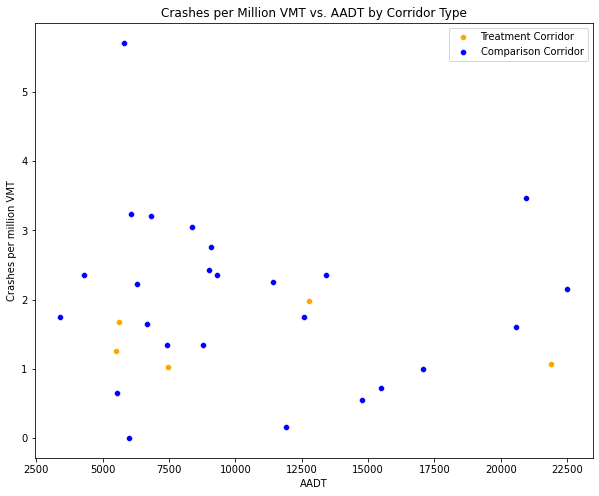

In [47]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(data=treatment_corr, x='AADT', y='crashes_per_million_VMT', color='orange', label='Treatment Corridor')
sns.scatterplot(data=non_treatment_corr, x='AADT', y='crashes_per_million_VMT', color='blue', label='Comparison Corridor')

plt.xlabel('AADT')
plt.ylabel('Crashes per million VMT')
plt.title('Crashes per Million VMT vs. AADT by Corridor Type')

# Add legend
plt.legend()

plt.savefig('cpmVMT_AADT_scatter.png')


In [111]:
diff_in_diff_dict = {
    '2015-08-06': ['Edgemont Street', 'Crescent Heights Boulevard', 'Griffin Avenue', '54th Street', 'Lincoln Park Avenue'],
    '2019-09-09': ['19th Street', '108th Street', '92nd Street', 'Evergreen Avenue', 'Townsend Avenue'],
    '2021-08-03': ['Colfax Avenue', 'Hauser Boulevard', 'Jefferson Boulevard', 'Beverly Glen Boulevard', '8th Street', 'Strathern Street', 'Gower Street'],
}

In [113]:
import pandas as pd
from datetime import datetime

# Assuming 'filtered_join' is your DataFrame and 'diff_in_diff_dict' is your dictionary
# Create a copy of the DataFrame to avoid modifying the original data
filtered_join_copy = filtered_join.copy()

# Convert the dates in the DataFrame to datetime objects
filtered_join_copy['date'] = pd.to_datetime(filtered_join_copy['COLLISION_DATE'])

# Initialize an empty DataFrame to store the counts
counts_df = pd.DataFrame(columns=['Street', 'Crashes Before', 'Crashes After', 'Days Elapsed Before', 'Days Elapsed After'])

# Iterate over the dictionary and count crashes before and after each date for each street
for date_str, streets in diff_in_diff_dict.items():
    date = datetime.strptime(date_str, '%Y-%m-%d').date()
    date = pd.to_datetime(date)  # Convert the date to a datetime object
    
    for street in streets:
        crashes_before_dict = len(filtered_join_copy[(filtered_join_copy['date'] < date) & (filtered_join_copy['adj_name_2'] == street)])
        crashes_after_dict = len(filtered_join_copy[(filtered_join_copy['date'] > date) & (filtered_join_copy['adj_name_2'] == street)])
        
        # Calculate the days elapsed before and after the date
        days_elapsed_before = (date - datetime(2011, 1, 1)).days
        days_elapsed_after = (datetime(2022,12,31) - date).days
        
        # Append the counts and days elapsed to the DataFrame
        counts_df = counts_df.append({'Street': street, 'Crashes Before': crashes_before_dict, 'Crashes After': crashes_after_dict,
                                      'Days Elapsed Before': days_elapsed_before, 'Days Elapsed After': days_elapsed_after}, ignore_index=True)


In [114]:
counts_df = counts_df.merge(AADT,how='left',left_on='Street',right_on='Zone Name')

In [115]:
counts_df['before_VMT'] = counts_df['Miles']*counts_df['AADT']*counts_df['Days Elapsed Before']
counts_df['before_crashes_per_million_VMT'] = counts_df['Crashes Before']/(counts_df['before_VMT']/1000000)

In [116]:
counts_df['after_VMT'] = counts_df['Miles']*counts_df['AADT']*counts_df['Days Elapsed After']
counts_df['after_crashes_per_million_VMT'] = counts_df['Crashes After']/(counts_df['after_VMT']/1000000)

In [117]:
counts_df['crashes_per_day_before'] = counts_df['Crashes Before']/counts_df['Days Elapsed Before']
counts_df['crashes_per_day_after'] = counts_df['Crashes After']/counts_df['Days Elapsed After']

In [118]:
diff_in_diff_treatment_streets = ['Edgemont Street', '19th Street', 'Colfax Avenue']

# Get all unique streets in the DataFrame
all_streets_did = filtered_join_copy['adj_name_2'].unique()

# Create the control streets by taking the set difference
diff_in_diff_control_streets = list(set(all_streets_did) - set(diff_in_diff_treatment_streets))

In [119]:
import pandas as pd

# Assuming you have the 'counts_df' DataFrame with the necessary columns

# Convert the before_crashes_per_million_VMT and after_crashes_per_million_VMT columns to float
counts_df['before_crashes_per_million_VMT'] = counts_df['before_crashes_per_million_VMT'].astype(float)
counts_df['after_crashes_per_million_VMT'] = counts_df['after_crashes_per_million_VMT'].astype(float)

# Define the treatment streets and control streets
diff_in_diff_treatment_streets = ['Edgemont Street', '19th Street', 'Colfax Avenue']
diff_in_diff_control_streets = counts_df[~counts_df['Street'].isin(diff_in_diff_treatment_streets)]['Street'].tolist()

# Calculate the means for before_crashes_per_million_VMT and after_crashes_per_million_VMT
mean_before_crashes_per_million_VMT_treatment = counts_df[counts_df['Street'].isin(diff_in_diff_treatment_streets)]['before_crashes_per_million_VMT'].mean()
mean_after_crashes_per_million_VMT_treatment = counts_df[counts_df['Street'].isin(diff_in_diff_treatment_streets)]['after_crashes_per_million_VMT'].mean()

mean_before_crashes_per_million_VMT_control = counts_df[counts_df['Street'].isin(diff_in_diff_control_streets)]['before_crashes_per_million_VMT'].mean()
mean_after_crashes_per_million_VMT_control = counts_df[counts_df['Street'].isin(diff_in_diff_control_streets)]['after_crashes_per_million_VMT'].mean()

# Create a new DataFrame for the means
means_data = {
    'Group': ['Treatment', 'Control'],
    'Mean Crashes per Day Before': [mean_before_crashes_per_million_VMT_treatment, mean_before_crashes_per_million_VMT_control],
    'Mean Crashes per Day After': [mean_after_crashes_per_million_VMT_treatment, mean_after_crashes_per_million_VMT_control]
}
means_df = pd.DataFrame(means_data)



In [120]:
means_df

,Group,Mean Crashes per Day Before,Mean Crashes per Day After
0,Treatment,1.434716,1.642013
1,Control,2.880319,1.923565


In [121]:
counts_df['Type'] = np.where(counts_df['Street'].isin(diff_in_diff_treatment_streets), 0, 1)

In [123]:
df_before = counts_df[['before_crashes_per_million_VMT', 'Type']]
df_before['t'] = 0
df_before.columns = ['Crashes', 'g', 't']

# data after the treatment
df_after = counts_df[['after_crashes_per_million_VMT', 'Type']]
df_after['t'] = 1
df_after.columns = ['Crashes', 'g', 't']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['gt'] = df_reg.g * df_reg.t

df_reg

/var/folders/bf/7kjr62fs6wq3x9hlt0xsr0w40000gn/T/ipykernel_35070/78541429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before['t'] = 0
/var/folders/bf/7kjr62fs6wq3x9hlt0xsr0w40000gn/T/ipykernel_35070/78541429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after['t'] = 1


,Crashes,g,t,gt
0,0.677583,0,0,0
1,3.939730,1,0,0
2,1.083939,1,0,0
3,3.068470,1,0,0
4,1.413344,1,0,0
5,1.601492,0,0,0
6,7.458147,1,0,0
7,2.164487,1,0,0
8,2.762240,1,0,0
9,1.591659,1,0,0


In [124]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.Crashes

lr.fit(X, y)

LinearRegression()

In [125]:
lr.coef_

array([ 1.44560362,  0.20729731, -1.16405178])

In [126]:
from statsmodels.formula.api import ols
ols = ols('Crashes ~ g + t + gt', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                Crashes   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1.507
Date:                Tue, 06 Jun 2023   Prob (F-statistic):              0.233
Time:                        10:50:36   Log-Likelihood:                -59.875
No. Observations:                  34   AIC:                             127.8
Df Residuals:                      30   BIC:                             133.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4347      0.865      1.658      0.1

In [65]:
treatment_corridors_short

['York', 'Colfax', '19th', 'Edgemont', 'Silver Lake']

In [66]:
# Define the function to check if a row contains any string in treatment_corridors_short
def label_row(row):
    if any(corridor in row['adj_name_2'] for corridor in treatment_corridors_short):
        return 'Treatment'
    else:
        return 'Comparison'
filtered_join_map = filtered_join.copy()

# Apply the function to create the new column
filtered_join_map['Label'] = filtered_join_map.apply(label_row, axis=1)


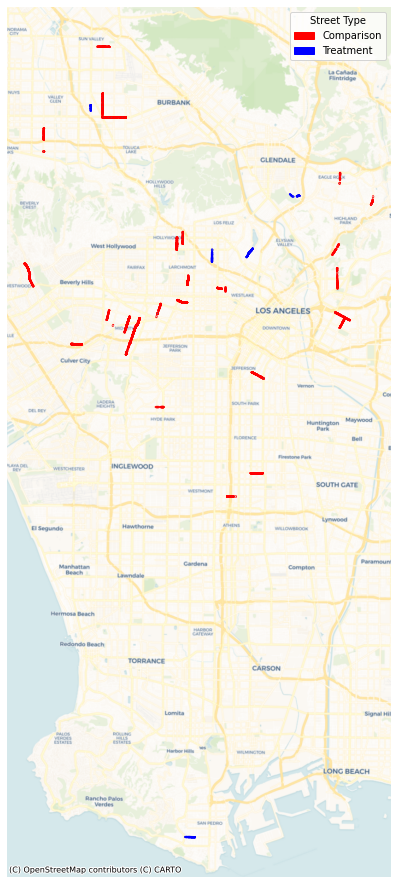

In [67]:
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Filter the data based on the "Treatment" category
treatment_data = filtered_join_map[filtered_join_map['Label'] == 'Treatment']
# Filter the data based on the "Comparison" category
comparison_data = filtered_join_map[filtered_join_map['Label'] == 'Comparison']

# Plot the "Treatment" data with thick edge color
ax = treatment_data.plot(column='Label', figsize=(16, 16), legend=False, linewidth=2, edgecolor='blue')

# Plot the "Comparison" data with a different color and no legend
comparison_data.plot(ax=ax, column='Label', legend=False, linewidth=2, edgecolor='red')

# Add basemap
ctx.add_basemap(ax, crs=filtered_join_map.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

# Create custom legend patches
comparison_patch = mpatches.Patch(color='red', label='Comparison')
treatment_patch = mpatches.Patch(color='blue', label='Treatment')

# Create the legend
ax.legend(handles=[comparison_patch, treatment_patch], title='Street Type')
ax.axis("off")


# Show the plot
plt.savefig('treatment_and_comparison_map.png', bbox_inches='tight', dpi=300)


In [ ]:
import pandas as pd
from datetime import datetime

# Assuming 'filtered_join' is your DataFrame and 'diff_in_diff_dict' is your dictionary
# Create a copy of the DataFrame to avoid modifying the original data
filtered_join_copy = filtered_join.copy()

# Convert the dates in the DataFrame to datetime objects
filtered_join_copy['date'] = pd.to_datetime(filtered_join_copy['COLLISION_DATE'])

# Initialize an empty DataFrame to store the counts
counts_df = pd.DataFrame(columns=['Street', 'Year', 'Crashes', 'Occurred'])

# Iterate over the dictionary and count crashes by year for each street
for date_str, streets in diff_in_diff_dict.items():
    date = datetime.strptime(date_str, '%Y-%m-%d').date()
    date = pd.to_datetime(date)  # Convert the date to a datetime object
    
    for street in streets:
        crashes_before = filtered_join_copy[(filtered_join_copy['date'] < date) & (filtered_join_copy['adj_name_2'] == street)]
        crashes_after = filtered_join_copy[(filtered_join_copy['date'] >= date) & (filtered_join_copy['adj_name_2'] == street)]
        
        # Count crashes by year before the date
        crashes_before_count = crashes_before.groupby(pd.Grouper(key='date', freq='Y')).size().reset_index(name='Crashes')
        crashes_before_count['Occurred'] = 'Before'
        
        # Count crashes by year after the date
        crashes_after_count = crashes_after.groupby(pd.Grouper(key='date', freq='Y')).size().reset_index(name='Crashes')
        crashes_after_count['Occurred'] = 'After'
        
        # Combine the counts for before and after into a single DataFrame
        crashes_count = pd.concat([crashes_before_count, crashes_after_count], ignore_index=True)
        crashes_count['Street'] = street
        
        # Append the counts to the main DataFrame
        counts_df = pd.concat([counts_df, crashes_count], ignore_index=True)

# Sort the DataFrame by street and year
counts_df = counts_df.sort_values(by=['Street', 'date']).reset_index(drop=True)


In [ ]:
counts_df['Occurred'] = counts_df['Occurred'].map({'Before': 0, 'After': 1})

In [ ]:
df_reg['Crashes'] = pd.to_numeric(df_reg['Crashes'], errors='coerce')